<a href="https://colab.research.google.com/github/alexandre-braga/OperationalResearch-CVRP-Gurobi/blob/main/Vers%C3%A3o_Final_Trabalho_PO_CVRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Site de onde as Instâncias foram retiradas:

http://vrp.galgos.inf.puc-rio.br/index.php/en/plotted-instances?data=E-n22-k4

Algumas Instâncias testadas:

http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//E/E-n22-k4.vrp

http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//E/E-n23-k3.vrp

Outras referências:

https://medium.com/jdsc-tech-blog/capacitated-vehicle-routing-problem-cvrp-with-python-pulp-and-google-maps-api-5a42dbb594c0

http://www.opl.ufc.br/post/tsp/

Possíveis soluções para eliminar Subciclos:

https://how-to.aimms.com/Articles/332/332-Explicit-Dantzig-Fulkerson-Johnson-formulation.html\

https://how-to.aimms.com/Articles/332/332-Miller-Tucker-Zemlin-formulation.html


#Analisando os Dados do Problema

Primeiramente temos os seguintes atributos nos arquivos:

* **Min no of trucks**: Nº mínimo de veículos para solucionar o problema
* **Dimension**: Nº de nós (clientes + depósito)
* **Capacity**: Capacidade máxima dos veículos
* **Node_Coord_Section**: ID do nó atrelado à suas coordenadas
* **Demand_Section**: ID do nó atrelado à sua demanda
* **Depot_Section**: Informações do depósito

Para facilitar na modelagem do problema, adotaremos o nó depósito de $ID = 1$ como nó de $ID = 0$ e os nós clientes seguintes terão seu valor $original - 1$
________________________


Podemos então denominar:

**Veículos**: $k \in U_+= \{1,...,p\}$

**Nós**: $V= \{0,...,n\}$

**Clientes**: $i \in V_+= \{1,...,n\}$

**Depósito**: $i \in \{0\}$

**Demandas**: $d_i$ de cada cliente $i \in V_+= \{1,...,n\}$

**Capacidade dos veículos por viagem**: $C \leq C_{max}$, com $ C= ∑d_j $, com $j \in V_+= \{1,...,n\}$ representando os clientes escolhidos em uma rota de um veículo k

**Objetivo**: Determinar o conjunto de rotas $S$, uma rota para cada veículo $k$, que inicia e termina no depósito. De tal maneira que todos os clientes sejam atentidos e o custo global do transporte minimizado. No caso escolihido, o custo do transporte se dará considerando as distâncias entre cada nó.

______________________


#**Código**

##**Imports e Inialização do Modelo**

###**Imports Relativos às Instâncias**

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
###Instância pequena da database###

instancia = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pesquisa Operacional/CSVs/E-n22-k4.csv', index_col='ID', skiprows=4)
header = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pesquisa Operacional/CSVs/E-n22-k4.csv', nrows=4, header=None)
header_info = header.head()



###Instância pequena 2 da database###

# instancia = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pesquisa Operacional/CSVs/E-n23-k3.csv', index_col='ID', skiprows=4)
# header = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pesquisa Operacional/CSVs/E-n23-k3.csv', nrows=4, header=None)
# header_info = header.head()




###Instância grande da database###

# instancia = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pesquisa Operacional/CSVs/E-n51-k5.csv', index_col='ID', skiprows=4)
# header = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pesquisa Operacional/CSVs/E-n51-k5.csv', nrows=4, header=None)
# header_info = header.head()


In [ ]:
instancia

,x_coord,y_coord,Demand
ID,,,
1,145,215,0
2,151,264,1100
3,159,261,700
4,130,254,800
5,128,252,1400
6,163,247,2100
7,146,246,400
8,161,242,800
9,142,239,100


In [ ]:
header_info = header_info.drop(header_info.columns[[-2,-1]], axis=1)
print(header_info.to_string(header=False))

0              K     4
1      DIMENSION    22
2       CAPACITY  6000
3  OPTIMAL VALUE   375


###**Imports Relativos ao Gurobi**

In [ ]:
%pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 67.0 MB/s eta 0:00:00


In [ ]:
import gurobipy as gp
from gurobipy import *
from gurobipy import GRB

In [ ]:
params = {
"WLSACCESSID": 'f9f94b68-f936-49fd-9136-aebd50c3ab9e',
"WLSSECRET": '4434d516-86fd-445c-a2bd-7b0014b0350d',
"LICENSEID": 923293,
}
env = gp.Env(params=params)
env.start() 

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 923293
Academic license - for non-commercial use only - registered to alexandre.braga@estudante.ufjf.br


<gurobipy.Env, Parameter changes: WLSAccessID=(user-defined), WLSSecret=(user-defined), LicenseID=923293>

###**Inicializando o Modelo**

In [ ]:
# @title Cria modelo vazio
m = gp.Model(env=env)

In [ ]:
# @title Pega informações do Header

#Minimum Vehicles
p = header_info[1].iloc[0]

#Dimensions
n = header_info[1].iloc[1]

#Capacity
Cmax = header_info[1].iloc[2]

#Optimal Value
optimal = header_info[1].iloc[3]

print(p, n, Cmax, optimal)

4 22 6000 375


In [ ]:
# @title Pega informações de Demanda
d = instancia['Demand'].to_numpy()
d

array([   0, 1100,  700,  800, 1400, 2100,  400,  800,  100,  500,  600,
       1200, 1300, 1300,  300,  900, 2100, 1000,  900, 2500, 1800,  700])

##**Criando as Variáveis Definitivas**

Seja $G = (V,E)$ um grafo que demonstra o local e rota do cliente

$V = \{0,1,...,n\}$ os nós desse grafo, sendo o nó $0$ o nó do deposito, e os nós de $1$ a $n$ os nós dos clientes

$E$ o conjunto de arestas conectando cada nó da maneira $e_{ij} = (i,j)$

Definimos:

$$x_{ijk} \in \{0,1\}$$ $$\forall k \in \{1,...,p\}$$ $$\forall (i,j) \in E$$

$x_{ijk}$: Variável binária que representa a decisão se um veículo $k$ viaja de um nó $i$ para um nó $j$

$y_{ik}$: Variável binária que representa se o veículo $k$ está em uso no nó $i$

$u_{i}$: Variável auxiliar contínua positiva

In [ ]:
# Define a variável binária x[i,j,k]
x = {}
for i in range(n):
    for j in range(n):
        for k in range(1,p+1):
            if i!=j:
                x[i,j,k] = m.addVar(vtype=GRB.BINARY, name="x_{}_{}_{}".format(i,j,k))

# Define a variável binária y[i,k]
y = {}
for i in range(n):
    for k in range(1,p+1):
        y[i,k] = m.addVar(vtype=GRB.BINARY, name="y_{}_{}".format(i,k))

# Define a variável contínua u[i]
u = {}
for i in range(n):
    u[i] = m.addVar(vtype=GRB.CONTINUOUS, name="u_{}".format(i))

##**Criando a Função Objetivo Definitiva**

De forma a encontrar o menor número de rotas possível, devemos assumir que existe um custo $c_{ij}$ representando o custo de ir de um cliente $i$ a um cliente $j$

E buscar otimizar a seguinte função objetivo para **cada rota**:

$$min
\sum_{j=1}^{n}
\sum_{i=1}^{n} c_{ij}x_{ij}$$

Sendo $x_{ij}$ uma variável binária indicando se o caminho de i a j faz parte da rota

______________________________

Como teremos um número p de rotas, podemos formular o objetivo como:


$$min
\sum_{k=1}^{p}
\sum_{j=1}^{n}
\sum_{i=1}^{n} c_{ij}x_{ijk}$$

Sendo $x_{ijk}$ uma variável binária indicando se o caminho de i a j faz parte da rota de um veículo k

____________

A partir dos dados das instâncias optamos por definir o custo $c_{ij}$ de ir de um cliente $i$ a um cliente $j$ como a distância dos locais dos mesmos. Pois possuímos as coordenadas $x$ e $y$ dos mesmos, e portanto, os dados permitem esse cálculo.

In [ ]:
# @title Gera as coordenadas dos Nós
import numpy as np

# Extract x and y coordinates of each node into separate arrays
x_coords = instancia['x_coord'].to_numpy()
y_coords = instancia['y_coord'].to_numpy()

# Initialize an empty distance matrix
c = np.zeros((n, n))

In [ ]:
# @title Cálcula Distância entre os Nós
for i in range(n):
    for j in range(n):
        distance =  np.linalg.norm([x_coords[i-1]-x_coords[j-1],y_coords[i-1]-y_coords[j-1]])
        if i == j:
          distance = 1e9
        c[i, j] = distance
        c[j, i] = distance

In [ ]:
# @title Função Objetivo $$min \sum_{k=1}^{p} \sum_{j=1}^{n} \sum_{i=1}^{n} c_{ij}x_{ijk}$$
m.setObjective(gp.quicksum(c[i,j]*x[i,j,k] for i in range(n) for j in range(n) for k in range(1,p+1) if i!=j), GRB.MINIMIZE)

##**Criando as Restrições Definitivas**

***Restrições:***

* ***1º - Fluxo Saída e Entrada:*** Garante somente 1 rota saindo de um nó $i$ para qualquer outro nó $j$ e por apenas um caminhão $k$. E garante somente 1 rota entrando em um nó $j$ de qualquer outro nó $i$ e por apenas um caminhão $k$

* ***2º - Fluxo Veículos Depósito:*** Garante que para todos os veículo, cada um deles tem que sair do depósito $0$ e ir para um nó $j$ e retornar de um nó $i$ para o depósito $0$. Garantindo o fluxo no depósito.

* ***3º - Capacidade Máxima de cada Veículo:*** Garante que a demanda total da rota de um veículo não ultrapasse a capacidade máxima estipulada.

* ***4º - Formulação MTZ Modificada:*** Objetiva acabar com os subciclos, e funciona de forma melhor do que a anterior

* ***5º - Restrição do $y_{ik}$:*** Não permite mais do que um k por i, além de forçar $y_{ik}$ e $y_{jk}$ a ser $1$ sempre que $x_{ijk}$ for

***Que Garantem respectivamente:***

Temos:

* ***Garantida pela 1º*** - 1 e somente 1 Caminhão por nó
* ***Garantida pela 1º*** - 1 e somente 1 Rota por nó
* ***Garantida pela 2º*** - $p$ rotas e caminhões saindo e retornando ao depósito
* ***Garantida pela 3º*** - Nenhum veículo $k$ pegando além de sua carga máxima $C_{max}$
* ***Garantida pela 4º*** - Não existem subciclos na solução
* ***Garantida pela 5º*** - Nenhum veículo $k$ ativando mais de um nó $i$, e $∀ y_{ik}$ o veículo correspondente é ativado por sua rota $x_{ijk}$

In [ ]:
# @title **1º Restrição**: Inflow e Outflow dos Nós $$\sum_{k=1}^{p} \sum_{i=0}^{n} x_{ijk} = 1$$ $$∀ j \in \{1,...,n\}$$ $$\sum_{k=1}^{p} \sum_{j=0}^{n} x_{ijk} = 1$$ $$∀ i \in \{1,...,n\}$$

for j in range(1,n):
    m.addConstr(gp.quicksum(x[i,j,k] for i in range(n) for k in range(1,p+1) if i!=j) == 1, name="one_node_inflow_{}".format(j))
    
for i in range(1,n):
    m.addConstr(gp.quicksum(x[i,j,k] for j in range(n) for k in range(1,p+1) if i!=j) == 1, name="one_node_outflow_{}".format(i))

In [ ]:
# @title **2º Restrição**: Inflow e Outflow do Depósito $$\sum_{j=1}^{n} x_{0jk} = 1$$ $$∀ k \in \{1,...,p\}$$ $$\sum_{i=1}^{n} x_{i0k} = 1$$ $$∀ k \in \{1,...,p\}$$

for k in range(1,p+1):
    m.addConstr(gp.quicksum(x[i,0,k] for i in range(1,n)) == 1, name="one_depot_inflow_{}".format(k))
    m.addConstr(gp.quicksum(x[0,j,k] for j in range(1,n)) == 1, name="one_depot_outflow_{}".format(k))

In [ ]:
# @title 3º Restrição: Capacidade do Veículo $$\sum_{i=0}^{n} \sum_{j=1}^{n} d_{j} x_{ijk} \leq C_{max}$$ $$∀ k \in \{1,...,p\}$$

for k in range(1,p+1):
    m.addConstr(gp.quicksum(d[j]*x[i,j,k] for i in range(n) for j in range(1,n) if i!=j) <= Cmax, name="vehicle_capacity_{}".format(k))


#$$\sum_{a=0}^{n}d_{a}y_{ak} + \sum_{j=0}^{n} d_{j} x_{ijk} \leq C_{max} $$ $$∀ k \in \{1,...,p\}$$
# for k in range(1,p+1):
#     for i in range(n):
#          m.addConstr(gp.quicksum(d[a]*y[a,k] for a in range (n)) + gp.quicksum(d[j]*x[i,j,k] for j in range(1,n) if i!=j) <= Cmax , name="vehicle_capacity_sum_{}_{}".format(i,k))

In [ ]:
# @title 4º Restrição: MTZ $$u_{i} - u_{j} + nx_{ijk} < n - 1$$ $$∀ i \in \{1,...,n\}$$ $$∀ j \in \{1,...,n\}$$ $$∀ k \in \{1,...,p\}$$ 
for k in range(1,p+1):
    for i in range(1,n):
        for j in range(1,n):
            if i!=j:
                m.addConstr(u[i] - u[j] + n*x[i,j,k] <= n -1, name="MTZ_constraint_{}_{}_{}".format(i,j,k))


# @title 4º Restrição: MTZ Modificado https://how-to.aimms.com/Articles/332/332-Miller-Tucker-Zemlin-formulation.html $$u_{i} - u_{j} \geq d_{j} - C_{max}(1 - x_{ijk}) $$ $$∀ i \in \{1,...,n\}$$ $$∀ j \in \{1,...,n\}$$ $$∀ k \in \{1,...,p\}$$  $$d_{j} \leq u_{j} \leq C_{max}$$  $$∀ j \in \{1,...,n\}$$
# for k in range(1,p+1):
#     for i in range(1,n):
#         for j in range(1,n):
#             if i!=j:
#                 m.addConstr(u[i] - u[j] >= d[j] - Cmax*(1 - x[i,j,k]), name="MTZ_Alternative_constraint_{}_{}_{}".format(i,j,k))

#                 #Relaxando o modelo, retiramos as seguintes restrições:
#                 #m.addConstr(u[j] >= d[j], name="MTZ_Alternative_constraint2_{}_{}_{}".format(i,j,k))
#                 #m.addConstr(u[j] <= Cmax, name="MTZ_Alternative_constraint3_{}_{}_{}".format(i,j,k))

Como o MTZ modificado funciona:

* Se um veículo $k$ vai de um nó $i$ para um nó $j$, temos $x_{ijk} = 1$ e a restrição pode ser reescrita como: $$u_{j} \geq u_{i} + d_{j}$$  $$u_{j} - d_{j}\geq u_{i}$$ Dessa maneira, garantimos que o valor de $u_{j}$ e maior que $u_{i}$, e além disso, pelo menos $q_{j}$ maior que o valor de $u_{i}$

* Se um veículo $k$ não vai de um nó $i$ para um nó $j$, temos $x_{ijk} = 0$ e a restrição pode ser reescrita como: $$u_{j} - d_{j} \geq u_{i} - C_{max}$$ Desse modo somado à restrição de que $$d_{j} \leq u_{j} \leq C_{max}$$  $$\forall j = \{1,...,n\}$$ O menor valor possível para $u_{j}$ sera $d_{j}$, e o maior será $C_{max}$. Consequentemente, $$u_{j} - d_{j}$$ Será pelo menos $0$ e $$u_{i} - C_{max}$$ Será no máximo $0$, o que garantirá a desigualdade

* Para conseguirmos encontrar uma solução viável para este trabalho, relaxamos a restrição $$d_{j} \leq u_{j} \leq C_{max}$$. O que permitiu se aproximar da função ótima

In [ ]:
# @title 5º Restrição: Restrições do $y_{ik}$ $$ \sum_{k=1}^{p}y_{ik} \leq 1$$ $$\forall i = \{1,...,n\}$$  $$x_{ijk} \leq My_{ik}$$ $$x_{ijk} \leq My_{jk}$$ $$\forall i = \{1,...,n\}$$ $$\forall j = \{1,...,n\}$$ $$\forall k = \{1,...,p\}$$

#Somente um k por i
for i in range(1,n):
    m.addConstr(gp.quicksum(y[i,k] for k in range(1,p+1)) <= 1, name="y_sum_restriction_{}".format(i))


#Força y_{ik} e y_{jk} a ser 1 sempre que x_{ijk} for
M = 1e9
for k in range(1,p+1):
    for i in range(n):
        for j in range(n):
            if i != j:
                m.addConstr(x[i,j,k] <= M*y[i,k], name="x_{}_{}_{}_ybigM".format(i,j,k))
                m.addConstr(x[i,j,k] <= M*y[j,k], name="x_{}_{}_{}_ybigM2".format(i,j,k))

##**Resultados**

In [ ]:
# @title Escreve o modelo em um arquivo .lp
m.write('PO - CVRP.lp')

In [ ]:
# @title Otimiza o Modelo
m.setParam('TimeLimit', 5*60)
m.optimize()

#check if optimal
if m.status == GRB.OPTIMAL:
  print("Solução Ótima Encontrada")
else:
  print("Sem Solução Ótima Encontrada")

#check if feasible
if m.status == GRB.INFEASIBLE:
  print("Sem Solução Viável Encontrada")
else:
  print("Solução Viável Encontrada")
  print("Objective value: ",m.objVal)

#check if unbounded
if m.status == GRB.UNBOUNDED:
  print("Sem Solução Limitada")
else: 
  print("Solução Limitada Encontrada")

Set parameter TimeLimit to value 300
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to alexandre.braga@estudante.ufjf.br
Optimize a model with 5451 rows, 1958 columns and 17976 nonzeros
Model fingerprint: 0xa79e907a
Variable types: 22 continuous, 1936 integer (1936 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [3e+00, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3549 rows and 26 columns
Presolve time: 0.11s
Presolved: 1902 rows, 1932 columns, 14276 nonzeros
Variable types: 21 continuous, 1911 integer (1911 binary)

Root relaxation: objective 2.961253e+02, 219 iterations, 0.0

In [ ]:
# @title Compara o valor da Função Objetivo com a Solução Ótima proposta na instância
print("Objective function value: ", m.objVal)
print("Original optimal Objective function value: ", optimal)

Objective function value:  486.23165493347256
Original optimal Objective function value:  375


###**Impressão das Variáveis**

In [ ]:
# @title Imprime $x_{ijk}$
for i in range(n):
    for j in range(n):
        for k in range(1,p+1):
            if i!=j and x[i,j,k].x == 1:
                print("x[{},{},{}]:".format(i,j,k), x[i,j,k].x)

x[0,9,2]: 1.0
x[0,11,1]: 1.0
x[0,16,3]: 1.0
x[0,18,4]: 1.0
x[1,17,4]: 1.0
x[2,3,1]: 1.0
x[3,6,1]: 1.0
x[4,5,2]: 1.0
x[5,12,2]: 1.0
x[6,8,1]: 1.0
x[7,2,1]: 1.0
x[8,10,1]: 1.0
x[9,4,2]: 1.0
x[10,13,1]: 1.0
x[11,7,1]: 1.0
x[12,14,2]: 1.0
x[13,0,1]: 1.0
x[14,0,2]: 1.0
x[15,1,4]: 1.0
x[16,19,3]: 1.0
x[17,20,4]: 1.0
x[18,15,4]: 1.0
x[19,21,3]: 1.0
x[20,0,4]: 1.0
x[21,0,3]: 1.0


Temos que ter garantido:

* 1 e somente 1 Caminhão por nó
* 1 e somente 1 Rota por nó
* P rotas e caminhões saindo e retornando ao depósito

In [ ]:
# @title Imprime $d_{j}$
print("Actual Vehicle Max Capacity:", Cmax)
for k in range(1,p+1):
    print("Vehicle {} demands:".format(k))
    sum = 0
    for j in range(n):
        for i in range(n):
            if i!=j and x[i,j,k].x == 1:
                sum+= d[j]
                print("d[{}]:".format(j), d[j])
    print("Total sum: ", sum)


Actual Vehicle Max Capacity: 6000
Vehicle 1 demands:
d[0]: 0
d[2]: 700
d[3]: 800
d[6]: 400
d[7]: 800
d[8]: 100
d[10]: 600
d[11]: 1200
d[13]: 1300
Total sum:  5900
Vehicle 2 demands:
d[0]: 0
d[4]: 1400
d[5]: 2100
d[9]: 500
d[12]: 1300
d[14]: 300
Total sum:  5600
Vehicle 3 demands:
d[0]: 0
d[16]: 2100
d[19]: 2500
d[21]: 700
Total sum:  5300
Vehicle 4 demands:
d[0]: 0
d[1]: 1100
d[15]: 900
d[17]: 1000
d[18]: 900
d[20]: 1800
Total sum:  5700


Temos que ter garantido:

* Nenhum veículo $k$ pegando além de sua carga máxima $C_{max}$

In [ ]:
# @title Imprime $y_{i,k}$
for i in range(n):
    for k in range(1,p+1):
        if y[i,k].x > 0.5:
            print("y[{},{}]:".format(i,k), y[i,k].x)

y[0,1]: 1.0
y[0,2]: 1.0
y[0,3]: 1.0
y[0,4]: 1.0
y[1,4]: 1.0
y[2,1]: 1.0
y[3,1]: 1.0
y[4,2]: 1.0
y[5,2]: 1.0
y[6,1]: 1.0
y[7,1]: 1.0
y[8,1]: 1.0
y[9,2]: 1.0
y[10,1]: 1.0
y[11,1]: 1.0
y[12,2]: 1.0
y[13,1]: 1.0
y[14,2]: 1.0
y[15,4]: 1.0
y[16,3]: 1.0
y[17,4]: 1.0
y[18,4]: 1.0
y[19,3]: 1.0
y[20,4]: 1.0
y[21,3]: 1.0


Temos que ter garantido:

* Nenhum veículo $k$ acessando mais de um nó $i$

In [ ]:
# @title Imprime $u_{i}$
for i in range(n):
    print("u[{}]:".format(i), u[i].x)

u[0]: 0.0
u[1]: 11.045454545454657
u[2]: 1.999999999999865
u[3]: 2.999999999999865
u[4]: 10.045454545454657
u[5]: 11.045454545454657
u[6]: 3.999999999999762
u[7]: 0.9999999999998614
u[8]: 4.999999999999709
u[9]: 9.045454545454657
u[10]: 19.99999999999986
u[11]: 0.0
u[12]: 12.045454545454657
u[13]: 20.99999999999986
u[14]: 13.045454545454657
u[15]: 10.045454545454657
u[16]: 9.045454545454657
u[17]: 14.045454545454657
u[18]: 9.045454545454657
u[19]: 10.045454545454657
u[20]: 15.045454545454657
u[21]: 11.045454545454657


Teríamos que ter garantido caso a restrição não fosse relaxada:

* Nenhum valor de $u$ menor do que as demandas possíveis, e nenhum valor de $u$ maior que a capacidade máxima

#Visualização dos Resultados

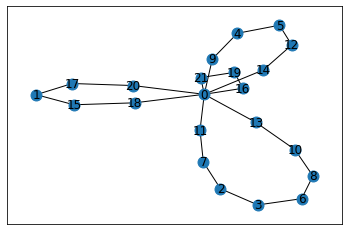

In [ ]:
# @title Plota as Rotas em Grafo
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for i in range(n):
    G.add_node(i)

# Add edges to the graph
for k in range(1,p+1):
  for i in range(n):
    for j in range(n):
      if i!=j and x[i,j,k].X > 0.9:
        G.add_edge(i, j)

# Draw the graph
#pos = nx.shell_layout(G)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=120)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
# @title Plota as Rotas em Vetor
for k in range(1,p+1):
    print("Vehicle {} routes:".format(k))
    for i in range(n):
        for j in range(n):
            if i!=j and x[i,j,k].X == 1:
                print("Route from {} to {}".format(i,j))

Vehicle 1 routes:
Route from 0 to 11
Route from 2 to 3
Route from 3 to 6
Route from 6 to 8
Route from 7 to 2
Route from 8 to 10
Route from 10 to 13
Route from 11 to 7
Route from 13 to 0
Vehicle 2 routes:
Route from 0 to 9
Route from 4 to 5
Route from 5 to 12
Route from 9 to 4
Route from 12 to 14
Route from 14 to 0
Vehicle 3 routes:
Route from 0 to 16
Route from 16 to 19
Route from 19 to 21
Route from 21 to 0
Vehicle 4 routes:
Route from 0 to 18
Route from 1 to 17
Route from 15 to 1
Route from 17 to 20
Route from 18 to 15
Route from 20 to 0


#Encerra programa

In [ ]:
m.dispose()
env.dispose()